In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries.discrete import DiscreteWavelet
from framework.dictionaries.undecimated import UndecimatedWavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
import copy

np.random.seed(666)

In [2]:
class Test:
    def __init__(self, nu_min=None, nu_max=None, nchannels=None, noise_frac=None, remove_frac=None, use_gridding=False, ftransform="nufft", use_wavelet=None, source_1=None, source_2=None, scenario=1):
        self.nu_min = nu_min
        self.nu_max = nu_max
        self.nchannels = nchannels
        self.noise_frac = noise_frac
        self.remove_frac = remove_frac
        self.use_gridding=use_gridding
        self.use_wavelet = use_wavelet
        self.ftransform = ftransform
        self.scenario = scenario
        self.nu = np.linspace(start=nu_min, stop=nu_max, num=nchannels)
        self.source_1 = copy.deepcopy(source_1)
        self.source_2 = copy.deepcopy(source_2)

        if self.source_1 is not None:
            self.source_1.nu = self.nu
            self.source_1.simulate()
                
        if self.source_2 is not None:
            self.source_2.nu = self.nu
            self.source_2.simulate()
                
        if scenario == 1:
            self.source = self.source_1
        elif scenario == 2:
            self.source = self.source_2
        else:
            self.source = self.source_1 + self.source_2
            
        if remove_frac:
            self.source.remove_channels(remove_frac)
        
        self.noiseless_source = copy.deepcopy(self.source)
        
        if noise_frac:
            if scenario == 1:
                self.avg_signal = np.abs(self.source_1.s_nu)
            elif scenario == 2:
                self.avg_signal = np.abs(self.source_2.s_nu)
            else:
                self.avg_signal = (np.abs(self.source_1.s_nu) + np.abs(self.source_2.s_nu))/2.0
            self.source.apply_noise(self.avg_signal/self.noise_frac)
                
        if use_gridding:
            gridding = Gridding(self.source)
            gridding_noiseless = Gridding(self.noiseless_source)
            self.source = gridding.run()
            self.noiseless_source = gridding_noiseless.run()
            
    def run(self, lambda_tv:float=None, lambda_tsv:float=None):
        self.parameter = Parameter()
        self.parameter.calculate_cellsize(dataset=self.source)
        
        dft = DFT1D(dataset=self.source, parameter=self.parameter)
        
        self.F_dirty = dft.backward(self.source.data)
        
        idx_noise = np.where(np.abs(self.parameter.phi)>self.parameter.max_faraday_depth/1.5)
        
        self.noise = np.std(0.5*(self.F_dirty[idx_noise].real + self.F_dirty[idx_noise].imag))
        
        if self.use_wavelet:
            #self.wavelet = DiscreteWavelet(wavelet_name=self.use_wavelet, mode="periodization")
            self.wavelet = UndecimatedWavelet(wavelet_name=self.use_wavelet)
        
        self.lambda_l1 = np.sqrt(2.0 * len(self.source.data) + 4.0 * np.sqrt(len(self.source.data)))*self.noise*0.5
        #lambda_l1 =np.sqrt(len(self.source.data) + np.sqrt(len(self.source.data)))*self.noise
        
        
        if lambda_tv is None:
            lambda_tv = 0.0
        
        if lambda_tsv is None:
            lambda_tsv = 0.0
            
        if self.ftransform == "nufft":
            nufft = NUFFT1D(dataset=self.source, parameter=self.parameter, solve=True)
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=nufft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=nufft)
        else:
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=dft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=dft)
            
        l1 = L1(reg=self.lambda_l1)
        tsv = TSV(reg=lambda_tsv)
        tv = TV(reg=lambda_tv)
        F_func = [chi2, l1, tsv]
        f_func = [chi2]
        g_func = [l1, tsv]

        F_obj = OFunction(F_func)
        f_obj = OFunction(f_func)
        g_obj = OFunction(g_func)
        
        self.parameter.data = self.F_dirty
        
        self.parameter.complex_data_to_real()
        
        if self.use_wavelet:
            self.parameter.data = self.wavelet.decompose(self.parameter.data)
        
        opt = FISTA(guess_param=self.parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=self.noise, verbose=True)
        self.obj, self.X = opt.run()
        
        if self.use_wavelet is not None:
            self.coeffs = copy.deepcopy(self.X.data)
            self.sparsity = len(np.nonzero(self.coeffs))/len(self.coeffs)
            self.X.data = self.wavelet.reconstruct(self.X.data)
        else:
            self.sparsity = len(np.nonzero(self.X.data))/ len(self.X.data)
        
        self.X.real_data_to_complex()
        
        self.X_residual = dft.backward(self.source.residual)
        
        self.X_restored = self.X.convolve() + self.X_residual
        
        self.res_noise = 0.5*(np.std(self.X_residual.real) + np.std(self.X_residual.imag))
        meaningful_signal = np.where(np.abs(self.parameter.phi) < self.parameter.max_faraday_depth)
        self.signal = np.mean(np.abs(self.X_restored[meaningful_signal]))
        self.peak_signal = np.max(np.abs(self.X_restored))
        self.rmse = np.sqrt(np.mean(self.res_noise**2))
        
        self.snr = self.signal / self.res_noise
        self.psnr = self.peak_signal / self.res_noise
        
        print("Signal-to-noise ratio: {0}".format(self.snr))
        print("Peak Signal-to-noise ratio: {0}".format(self.psnr))
        print("Normalized Root Mean Squared Error: {0}".format(self.rmse))
        
        self.lags, self.autocorr_res, self.autocorr_res_sq, self.bound, self.percentage_real_in, self.percentage_imag_in, self.percentage_real_in_sq, self.percentage_imag_in_sq = self.source.assess_residuals()
        
        self.residual_comparison = self.noiseless_source.data - self.source.model_data
        
        self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

        # Data
        self.ax[0,0].plot(self.source.lambda2, self.source.data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,0].plot(self.source.lambda2, self.source.data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,0].plot(self.source.lambda2, np.abs(self.source.data), 'g.', label=r"$|P|$")
        self.ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,0].set_ylabel(r'Jy/beam')
        self.ax[0,0].title.set_text("Data")

        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,0].plot(self.parameter.phi, np.abs(self.F_dirty), 'k-', label=r"|P|")
        self.ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,0].set_xlim([-1000,1000])

        # Model
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,1].plot(self.source.lambda2, np.abs(self.source.model_data), 'g.', label=r"$|P|$")
        self.ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,1].set_ylabel(r'Jy/beam')
        self.ax[0,1].title.set_text("Model")

        self.ax[1,1].plot(self.parameter.phi, self.X.data.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,1].plot(self.parameter.phi, self.X.data.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,1].plot(self.parameter.phi, np.abs(self.X.data), 'k-', label=r"$|P|$")
        self.ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
        self.ax[1,1].set_xlim([-1000,1000])

        # Residual

        # Model
        self.ax[0,2].plot(self.source.lambda2, self.source.residual.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,2].plot(self.source.lambda2, self.source.residual.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,2].plot(self.source.lambda2, np.abs(self.source.residual), 'g.', label=r"$|P|$")
        self.ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,2].set_ylabel(r'Jy/beam')
        self.ax[0,2].title.set_text("Residual")

        self.ax[1,2].plot(self.parameter.phi, self.X_residual.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,2].plot(self.parameter.phi, self.X_residual.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,2].plot(self.parameter.phi, np.abs(self.X_residual), 'k-', label=r"$|P|$")
        self.ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,2].set_xlim([-1000,1000])
        
        if self.use_wavelet:
            self.ax[0,3].plot(self.coeffs)
            self.ax[0,3].title.set_text("Coefficients")

        self.ax[1,3].plot(self.parameter.phi, self.X_restored.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,3].plot(self.parameter.phi, self.X_restored.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,3].plot(self.parameter.phi, np.abs(self.X_restored), 'k-', label=r"$|P|$")
        self.ax[1,3].set_xlim([-1000,1000])
        self.ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,3].title.set_text("Restored")
        
        self.fig.tight_layout()

In [3]:
source_1 = FaradayThinSource(s_nu=0.0035, phi_gal=-200, spectral_idx=1.0)
source_2 = FaradayThickSource(s_nu=0.0035, phi_fg=140, phi_center=200, spectral_idx=1.0)

In [4]:
nsigma = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
remove_frac = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

In [5]:
test_objs = []
for nsig in nsigma:
    for remv_frac in remove_frac:
        test_objs.append(Test(nu_min=1.008e9, nu_max=2.031e9, nchannels=1000, noise_frac=nsig, remove_frac=remv_frac, scenario=1, use_wavelet="db4", source_1=source_1, source_2=source_2))

In [6]:
nid = len(nsigma)*len(remove_frac)
for _id in range(0, nid):
    test_objs[_id].run()

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Iterations set to 23
Iteration:  0  objective function value: 0.00669
Signal-to-noise ratio: 1.6401985494622302
Peak Signal-to-noise ratio: 81.43044991336326
Normalized Root Mean Squared Error: 3.809067857218906e-05
FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 23419.848
Iterations set to 21
Iteration:  0  objective function value: 0.00702
Signal-to-noise ratio: 1.411181737011413
Peak Signal-to-noise ratio: 59.30200964970331
Normalized Root Mean Squared Error: 5.256169970380142e-05
FWHM of the main peak of the RMTF: 54.537 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21787.658
Iterations set to 20
Iteration:  0  ob

/tmp/ipykernel_114172/1269299935.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))


Iterations set to 19
Iteration:  0  objective function value: 0.00285
Signal-to-noise ratio: 1.5240768703432648
Peak Signal-to-noise ratio: 105.84667169472301
Normalized Root Mean Squared Error: 3.011893932125531e-05
FWHM of the main peak of the RMTF: 57.319 rad/m^2
Maximum recovered width structure: 131.677 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 17166.998
Iterations set to 18
Iteration:  0  objective function value: 0.00231
Signal-to-noise ratio: 1.6457137990823387
Peak Signal-to-noise ratio: 112.69839267454022
Normalized Root Mean Squared Error: 2.8858223231509328e-05
FWHM of the main peak of the RMTF: 58.835 rad/m^2
Maximum recovered width structure: 143.752 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14679.265
Iterations set to 16
Iteration:  0  objective function value: 0.00160
Signal-to-noise ratio: 1.5529375980925069
Peak Signal-to-noise ratio: 42.18356902886122
Normalized Root Mean Squared Error: 3.683871182147413

limit_output extension: Maximum message size of 10000 exceeded with 10005 characters

In [24]:
selected_test = test_objs[7]

In [25]:
selected_test.remove_frac

0.7

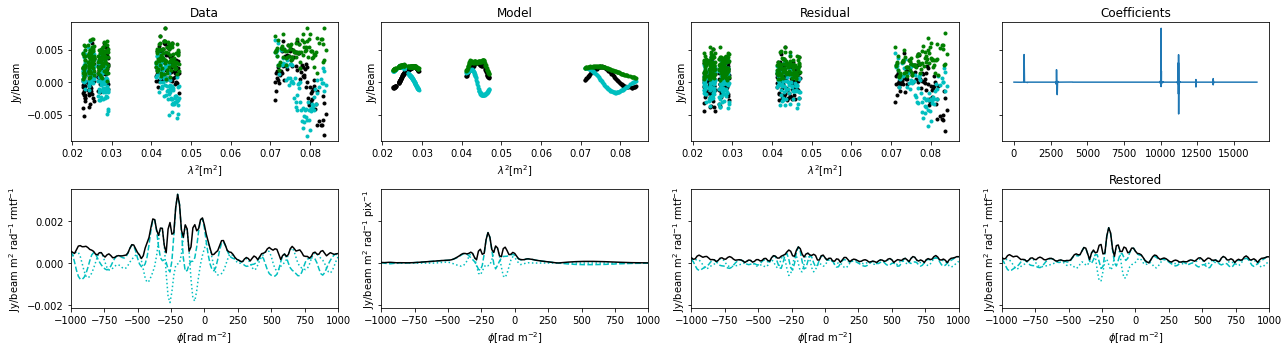

In [26]:
selected_test.fig

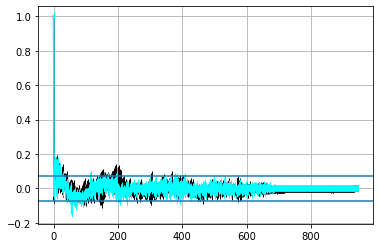

In [10]:
plt.plot(selected_test.lags, selected_test.autocorr_res.real, '|-', c="black", label=r"Real part")
plt.plot(selected_test.lags, selected_test.autocorr_res.imag, '|-', c="cyan", label=r"Imaginary part")
plt.axhline(-selected_test.bound)
plt.axhline(selected_test.bound)
plt.grid()

In [11]:
#from framework.base import boxpierce, ljungbox
#ljungbox(selected_test.autocorr_res.real, [1, 400, 600, 800, 1000, 1200, len(selected_test.lags)-1])

In [12]:
#boxpierce(selected_test.autocorr_res.real, [1, 400, 600, 800, 1000, 1200, len(selected_test.lags)-1])

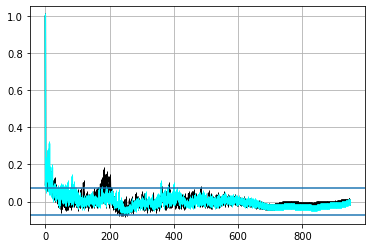

In [13]:
plt.plot(selected_test.lags, selected_test.autocorr_res_sq.real, '|-', c="black", label=r"Real part")
plt.plot(selected_test.lags, selected_test.autocorr_res_sq.imag, '|-', c="cyan", label=r"Imaginary part")
plt.axhline(-selected_test.bound)
plt.axhline(selected_test.bound)
plt.grid()

In [14]:
selected_test.percentage_real_in, selected_test.percentage_imag_in

(96.83544303797468, 96.83544303797468)

In [15]:
std_res_real = np.std(selected_test.source.residual.real)
print(std_res_real)

0.0016628280915141696


In [16]:
std_res_imag = np.std(selected_test.source.residual.imag)
print(std_res_imag)

0.001661041088322438


In [17]:
selected_test.avg_signal/selected_test.noise_frac

0.00175

In [18]:
selected_test.psnr

45.914777764651475

In [19]:
test_objs[9].rmse

3.0267055990407243e-05

In [20]:
import pandas as pd

In [21]:
pd.DataFrame(np.array_split([x.psnr for x in test_objs], len(remove_frac)), columns=remove_frac, index=1/nsigma)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
2.0,81.430450,59.302010,55.640191,45.914778,45.884249,37.903630,38.102102,14.067733,12.270191
3.0,107.550510,80.919344,64.212752,72.500471,73.928997,43.155044,39.498510,27.501123,10.050462
4.0,129.585442,104.621162,92.131397,105.846672,112.698393,42.183569,54.993778,22.319566,19.138881
5.0,160.145321,128.882189,129.891803,134.121279,96.846148,79.804810,63.806382,72.989262,34.120029
6.0,188.115746,144.540356,127.055077,144.938092,137.477502,66.455760,94.516786,37.587801,26.798636
7.0,200.466059,149.794403,148.573609,185.543370,155.393915,88.271878,77.343398,50.724559,24.385294
8.0,231.192573,188.091470,169.205401,166.046803,226.543198,87.608389,69.798913,37.689355,39.230503
9.0,257.037636,215.909552,195.084155,180.884950,156.564098,140.801963,85.742508,39.175263,48.554259
10.0,269.136834,201.039268,200.050066,169.533633,147.450600,178.622066,124.745291,48.044958,11.959257


In [22]:
pd.DataFrame(np.array_split([x.rmse for x in test_objs], len(remove_frac)), columns=remove_frac, index=1/nsigma)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
2.0,0.000038,0.000053,0.000056,0.000054,0.000056,0.000069,0.000076,0.000119,0.000189
3.0,0.000030,0.000036,0.000039,0.000038,0.000039,0.000047,0.000056,0.000080,0.000179
4.0,0.000025,0.000030,0.000031,0.000030,0.000029,0.000037,0.000055,0.000065,0.000076
5.0,0.000020,0.000024,0.000026,0.000024,0.000023,0.000026,0.000039,0.000039,0.000052
6.0,0.000017,0.000021,0.000021,0.000021,0.000021,0.000028,0.000033,0.000060,0.000051
7.0,0.000016,0.000019,0.000019,0.000019,0.000018,0.000022,0.000027,0.000055,0.000072
8.0,0.000014,0.000017,0.000017,0.000018,0.000016,0.000021,0.000026,0.000059,0.000042
9.0,0.000013,0.000015,0.000016,0.000013,0.000016,0.000016,0.000025,0.000043,0.000054
10.0,0.000012,0.000015,0.000015,0.000015,0.000013,0.000018,0.000023,0.000038,0.000194


In [23]:
pd.DataFrame(np.array_split([x.sparsity*100.0 for x in test_objs], len(remove_frac)), columns=remove_frac, index=1/nsigma)

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8
2.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
3.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
4.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
5.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.002959,0.00651
6.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
7.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
8.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
9.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
10.0,0.0014,0.001268,0.002255,0.002566,0.002639,0.00315,0.004555,0.006033,0.00651
